In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
df = pd.read_csv("triceps.csv")
df

,age,lntriceps,triceps
0,12.050000,1.223776,3.4
1,9.910000,1.386294,4.0
2,10.040000,1.435084,4.2
3,11.490000,1.435084,4.2
4,10.120000,1.481605,4.4
...,...,...,...
887,27.150000,1.648659,5.2
888,7.910000,1.916923,6.8
889,7.990000,1.435084,4.2
890,14.630000,2.197225,9.0


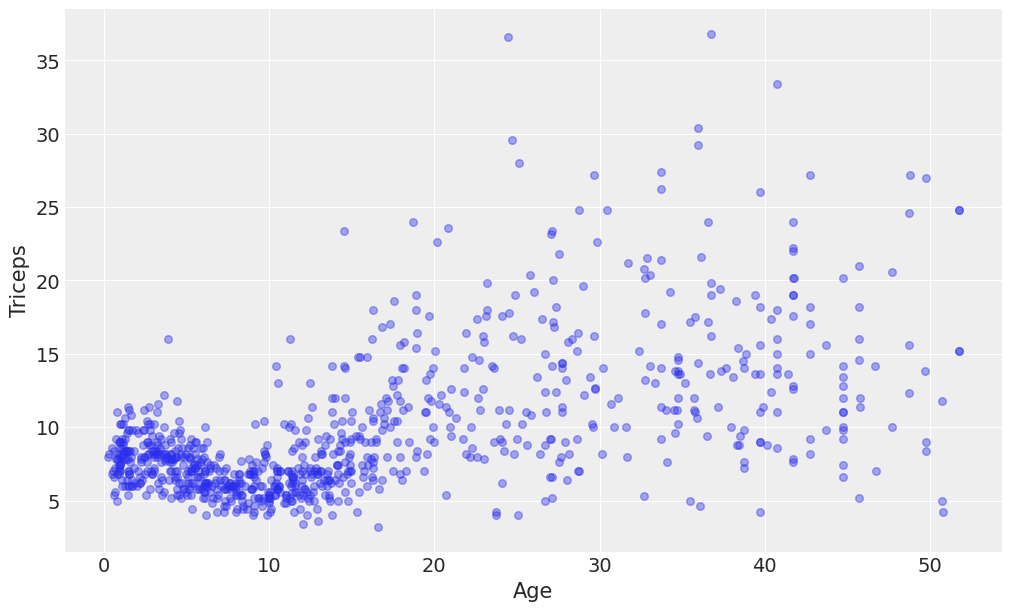

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["age"], df["triceps"], s=30, alpha=0.4)
ax.set_xlabel("Age")
ax.set_ylabel("Triceps");

In [5]:
def truncate(x, l):
    x = (x - l) * (x >= l)
    return x

In [6]:
formula = "triceps ~ age + truncate(age, 5) + truncate(age, 10) + truncate(age, 20) + truncate(age, 30) + truncate(age, 40)"
model = bmb.Model(formula, df)
model

Formula: triceps ~ age + truncate(age, 5) + truncate(age, 10) + truncate(age, 20) + truncate(age, 30) + truncate(age, 40)
Family name: Gaussian
Link: identity
Observations: 892
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 9.7024, sigma: 25.811)
    age ~ Normal(mu: 0.0, sigma: 0.9292)
    truncate(age, 5) ~ Normal(mu: 0.0, sigma: 0.9687)
    truncate(age, 10) ~ Normal(mu: 0.0, sigma: 1.0823)
    truncate(age, 20) ~ Normal(mu: 0.0, sigma: 1.572)
    truncate(age, 30) ~ Normal(mu: 0.0, sigma: 2.8286)
    truncate(age, 40) ~ Normal(mu: 0.0, sigma: 7.6954)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 4.916)

In [7]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [triceps_sigma, truncate(age, 40), truncate(age, 30), truncate(age, 20), truncate(age, 10), truncate(age, 5), age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.389,0.528,7.373,9.333,0.015,0.011,1270.0,1394.0,1.0
age,-0.205,0.148,-0.483,0.079,0.005,0.003,1007.0,1121.0,1.0
"truncate(age, 5)",-0.129,0.223,-0.545,0.283,0.008,0.005,863.0,1006.0,1.0
"truncate(age, 10)",1.000,0.144,0.733,1.264,0.005,0.003,941.0,1229.0,1.0
"truncate(age, 20)",-0.461,0.122,-0.696,-0.242,0.004,0.003,884.0,1168.0,1.0
"truncate(age, 30)",-0.186,0.140,-0.455,0.076,0.005,0.003,850.0,1045.0,1.0
"truncate(age, 40)",-0.019,0.158,-0.314,0.264,0.005,0.003,1087.0,1212.0,1.0
triceps_sigma,3.761,0.091,3.592,3.933,0.002,0.002,1835.0,1599.0,1.0


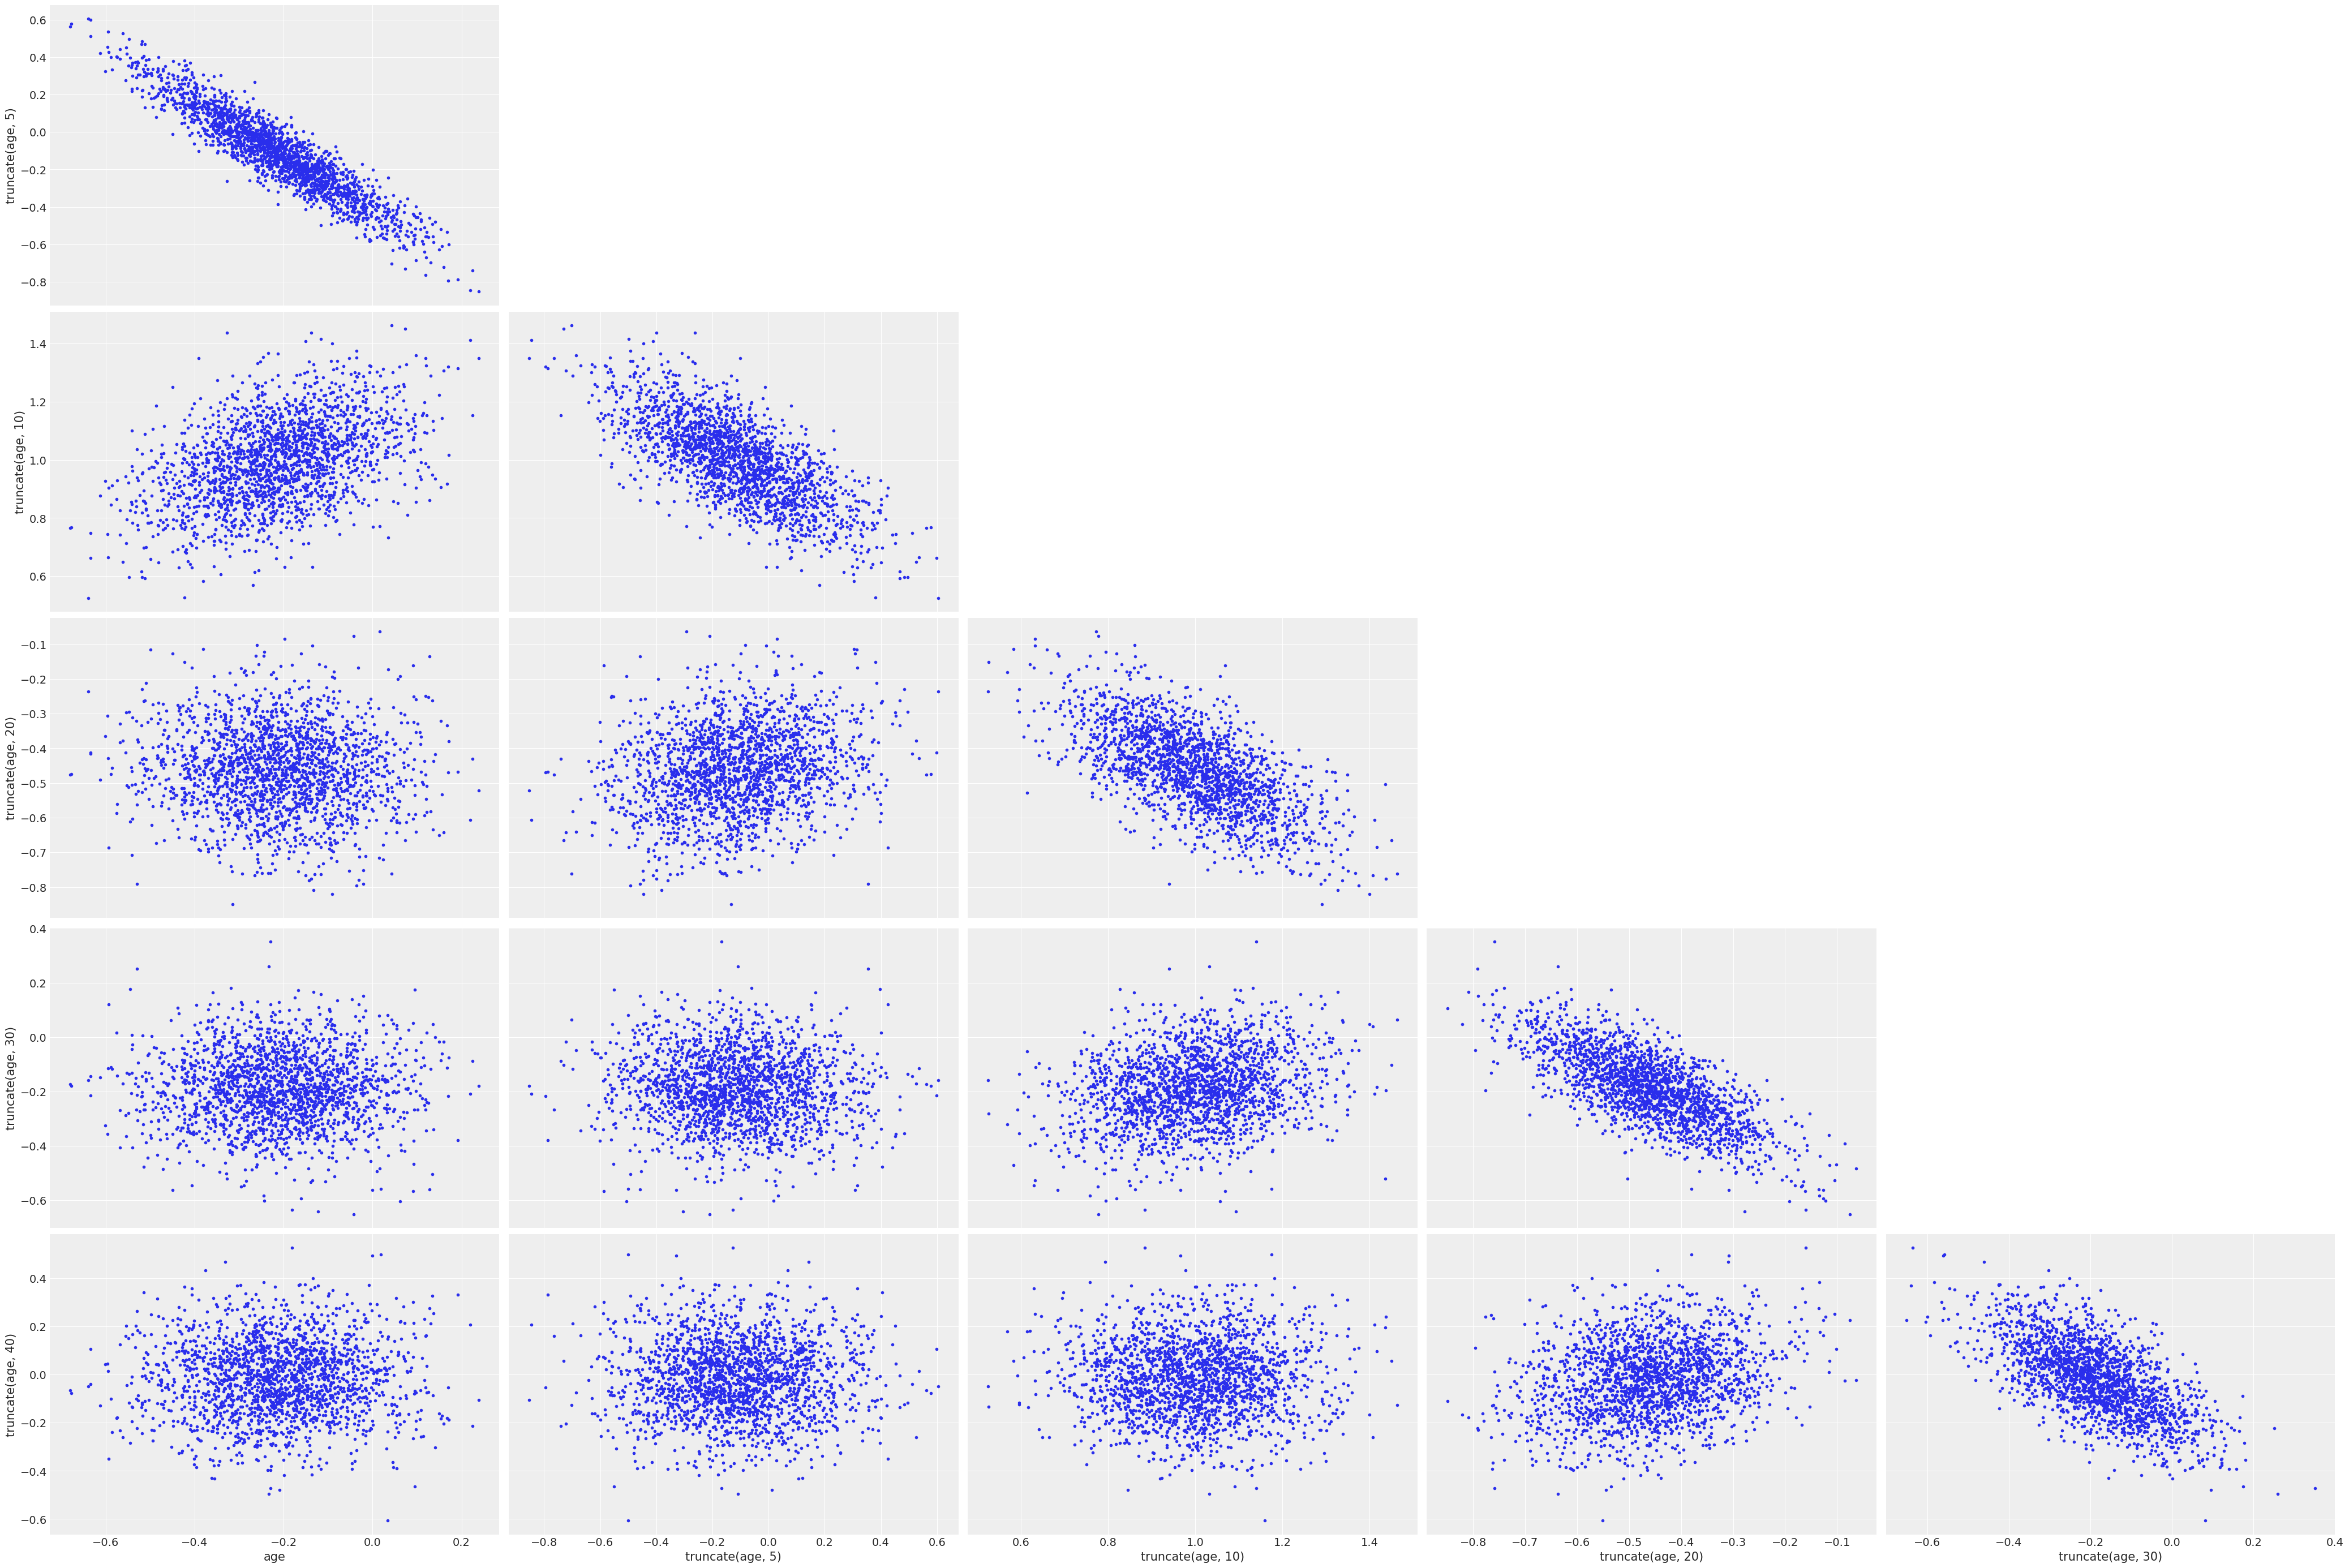

In [10]:
az.plot_pair(idata, var_names=["~Intercept", "~triceps_sigma"]);

In [8]:
df_new = pd.DataFrame({"age": np.linspace(df["age"].min(), df["age"].max(), num=100)})
model.predict(idata, data=df_new)

In [9]:
y_hat = idata.posterior["triceps_mean"].stack(sample=("chain", "draw")).values
hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)

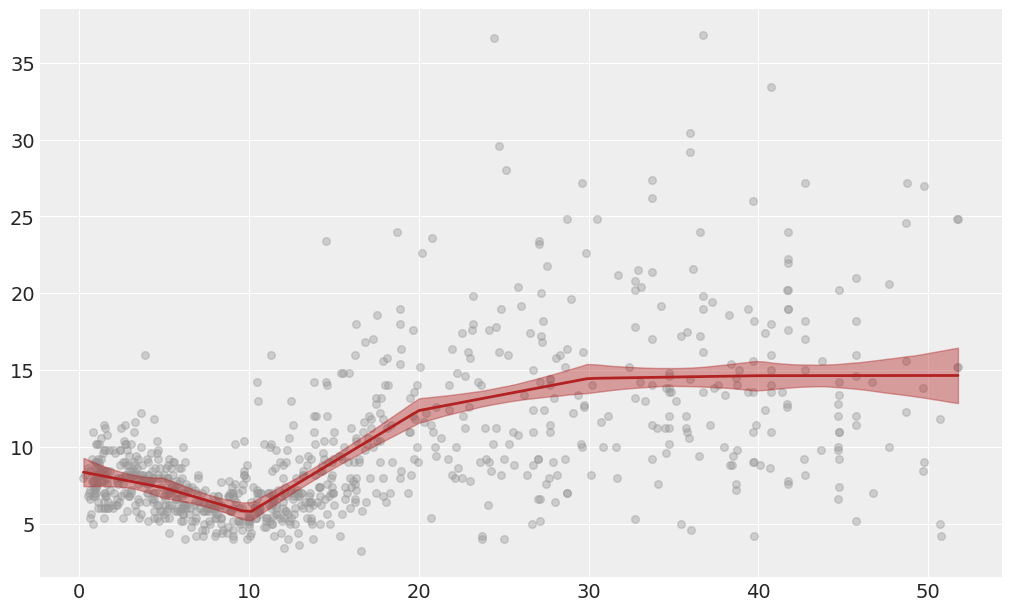

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["age"], df["triceps"], s=30, alpha=0.4, color="0.6")
ax.plot(df_new["age"], y_hat.mean(1), lw=2, color="firebrick")
ax.fill_between(df_new["age"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick");

In [11]:
model.predict(idata, kind="pps", data=df_new)
y_pp = idata.posterior_predictive["triceps"].values

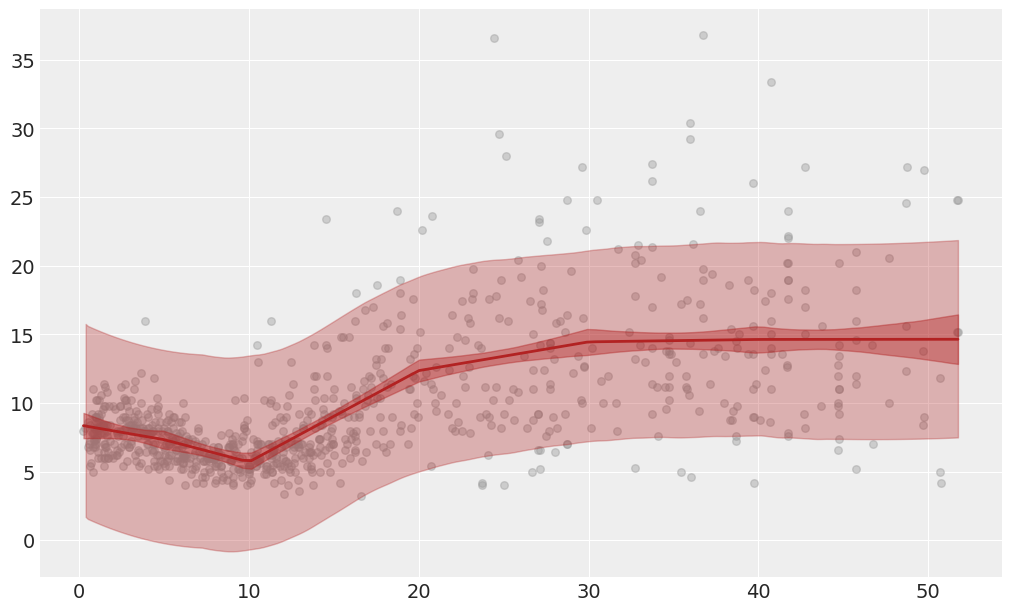

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["age"], df["triceps"], s=30, alpha=0.4, color="0.6")
ax.plot(df_new["age"], y_hat.mean(1), lw=2, color="firebrick")
ax.fill_between(df_new["age"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick");
az.plot_hdi(df_new["age"], y_pp, color="firebrick", ax=ax, fill_kwargs={"alpha": 0.3});

This is a good example for a model with variable standard deviation. Note how the width of the band is very too much for lower values of x, and it is not enough for higher values of x.